In [1]:
#Setting up paths for data
data_root = "/home/jovyan/nnunet2-mig-7g-80gb-datavol-1/data/Brain-Tumor-Classification" 

tr_base  = data_root+"/Training"
te_base  = data_root+"/Testing"

In [2]:
#Setting up Transforms 
from pathlib import Path
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler # remember subset when you divide into training and validation
from torchvision import datasets, transforms, utils, models # add models when you import pretrained models for transfer learning
import os
import torch
import numpy as np

IMG_SIZE = 512

def zscore(x):  # MRI-friendly
    return (x - x.mean()) / (x.std() + 1e-8)

train_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert('L')),                 # use 'RGB' if truly 3-ch
    transforms.Grayscale(num_output_channels=3), 
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.02,0.02), scale=(0.95,1.05)),
    transforms.RandomApply([transforms.GaussianBlur(3, (0.1, 1.0))], p=0.2),
    transforms.ColorJitter(brightness=0.10, contrast=0.10),
    transforms.ToTensor(),
    #transforms.Lambda(zscore),
])

eval_tf = transforms.Compose([
    transforms.Lambda(lambda im: im.convert('L')),
    transforms.Grayscale(num_output_channels=3), 
    transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    transforms.ToTensor(),
    #transforms.Lambda(zscore),
])

In [3]:
trainset=datasets.ImageFolder(tr_base, transform=train_tf)
valset = datasets.ImageFolder(tr_base, transform=eval_tf)
testset=datasets.ImageFolder(te_base, transform=eval_tf)

print(valset)

print(testset.classes)
print(trainset.classes)
print(valset.classes)

val_fraction=0.2

idxs = list(range(len(valset)))
rng = np.random.default_rng(42)
rng.shuffle(idxs)

n_val = int(len(idxs) * val_fraction)
val_idx = idxs[:n_val]
train_idx = idxs[n_val:]

trainset = Subset(trainset, train_idx)
valset   = Subset(valset,   val_idx)

class_names = datasets.ImageFolder(tr_base).classes

Dataset ImageFolder
    Number of datapoints: 2902
    Root location: /home/jovyan/nnunet2-mig-7g-80gb-datavol-1/data/Brain-Tumor-Classification/Training
    StandardTransform
Transform: Compose(
               Lambda()
               Grayscale(num_output_channels=3)
               Resize(size=(512, 512), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [4]:
def get_targets_from_dataset(ds) -> np.ndarray:
    """Return class indices for ImageFolder or Subset(ImageFolder)."""
    if isinstance(ds, Subset):
        base, idxs = ds.dataset, ds.indices
        if hasattr(base, "targets"):
            return np.asarray(base.targets, dtype=int)[idxs]
        return np.asarray([base.samples[i][1] for i in idxs], dtype=int)
    # ImageFolder
    if hasattr(ds, "targets"):
        return np.asarray(ds.targets, dtype=int)
    return np.asarray([y for _, y in ds.samples], dtype=int)

In [5]:

# assume you already created trainset (ImageFolder or Subset(ImageFolder))
targets = get_targets_from_dataset(trainset)              # shape [N]
num_classes = int(targets.max() + 1)

# inverse-frequency class weights (simple & effective)
class_counts  = np.bincount(targets, minlength=num_classes).astype(float)
class_weights = 1.0 / np.maximum(class_counts, 1.0)      # avoid div/0
sample_weights = class_weights[targets]                   # per-sample weight

sampler = WeightedRandomSampler(
    weights=torch.as_tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),   # one epoch ~= dataset size
    replacement=True                   # allows oversampling of minority class
)

BATCH = 4
WORKERS = 4


train_loader = DataLoader(
    trainset,
    batch_size=BATCH,
    shuffle=False,
    sampler=sampler,
    num_workers=WORKERS,
    pin_memory=True,
    drop_last=True,                    # optional: keeps batch size stable
)

# validation/test loaders stay standard (no sampler)
val_loader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=WORKERS, pin_memory=True)

In [6]:
import torch.nn as nn
from torchvision import models

def build_model(n_classes, freeze_backbone=False):
    """
    Build a MobileNetV3 model pretrained on ImageNet-1K,
    replace classification head for custom number of classes,
    and optionally freeze backbone layers.
    """
    # 1️⃣ Load pretrained Swin Transformer Base
    model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
    

    # 2️⃣ Replace classifier head
    in_feats = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_feats, n_classes)
    if freeze_backbone:
        for p in model.features.parameters():
            p.requires_grad = False
    return model


model = build_model(n_classes=4, freeze_backbone=False)
print(model)

# Verify output
import torch
x = torch.randn(2, 3, 512, 512)
out = model(x)
print(out.shape)  # → [2, 4]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [85]:
# ----------------------------
# 3) Training utilities
# ----------------------------
class EarlyStopper:
    def __init__(self, patience=8, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = None
        self.count = 0

    def step(self, metric):
        if self.best is None or metric > self.best + self.min_delta:
            self.best = metric
            self.count = 0
            return False  # do not stop

In [106]:
import contextlib
import torch
import torch.nn.functional as F

def epoch_run(model, loader, criterion, device, train: bool, use_amp: bool,
              optimizer=None, scaler=None):
    assert (train and optimizer is not None and scaler is not None) or (not train)

    model.train() if train else model.eval()

    total = 0
    running_loss = 0.0
    correct = 0

    # no graph during evaluation
    cm = contextlib.nullcontext() if train else torch.no_grad()

    with cm:
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            with torch.amp.autocast('cuda', enabled=(use_amp and device.type == 'cuda')):
                logits = model(xb)
                loss = criterion(logits, yb)

            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            running_loss += loss.detach().float().item() * xb.size(0)
            pred = logits.argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)

    return running_loss / total, correct / total


In [10]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def to_device(batch, device):
    x, y = batch
    return x.to(device, non_blocking=True), y.to(device, non_blocking=True)

In [7]:
from sklearn.metrics import f1_score

@torch.no_grad()
def compute_f1(model, loader, device, average="macro"):
    model.eval()
    all_preds, all_tgts = [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        preds = logits.argmax(1)
        all_preds.append(preds.detach().cpu())
        all_tgts.append(yb.detach().cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_tgts).numpy()
    return f1_score(y_true, y_pred, average=average)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

Device: cuda
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Train uses sampler: WeightedRandomSampler
Val uses sampler:   SequentialSampler
Test uses sampler:  SequentialSampler
Epoch 01/500 | train_loss=0.5428 acc=0.8467 | val_loss=1.2459 acc=0.4539 F1=0.3875 (✅ best loss & 💙 best acc & 🟣 best F1)
Epoch 02/500 | train_loss=0.3315 acc=0.9527 | val_loss=1.1344 acc=0.5235 F1=0.5085 (✅ best loss & 💙 best acc & 🟣 best F1)
Epoch 03/500 | train_loss=0.3020 acc=0.9640 | val_loss=1.0364 acc=0.5304 F1=0.5352 (✅ best loss & 💙 best acc & 🟣 best F1)
Epoch 04/500 | train_loss=0.2748 acc=0.9783 | val_loss=0.6586 acc=0.7757 F1=0.7635 (✅ best loss & 💙 best acc & 🟣 best F1)
Epoch 05/500 | train_loss=0.2372 acc=0.9922 | val_loss=0.3968 acc=0.9217 F1=0.9218 (✅ best loss & 💙 best acc & 🟣 best F1)
Epoch 06/500 | train_loss=0.2222 acc=0.9957 | val_loss=0.4528 acc=0.8974 F1=0.8914
Epoch 07/500 | train_loss=0.2253 acc=0.9952 | val_loss=0.7238 acc=0.8000 F1=0.8000
Epoch 08/500 | t

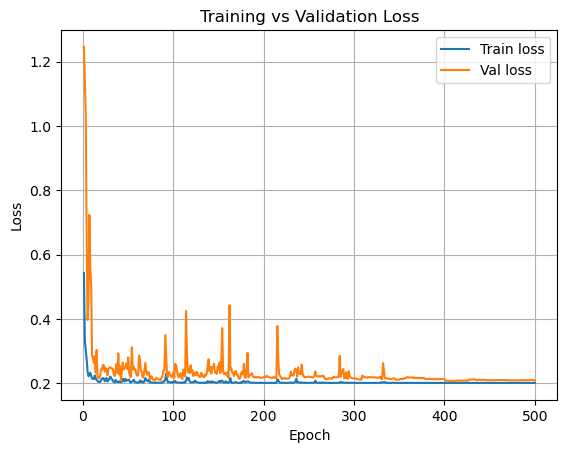

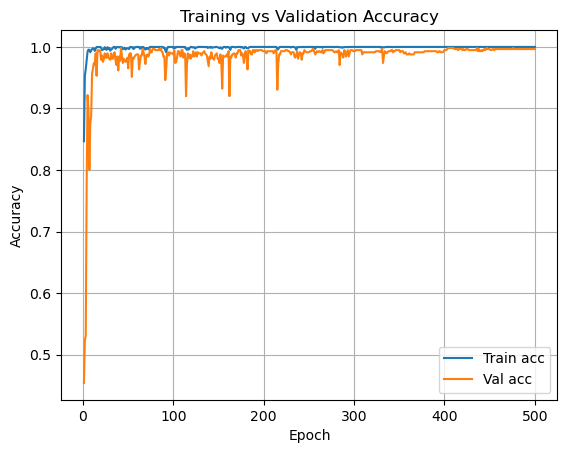

/tmp/ipykernel_40425/1421969170.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=device)



Test classification report:
                  precision    recall  f1-score   support

    glioma_tumor     1.0000    0.2700    0.4252       100
meningioma_tumor     0.6786    0.9913    0.8057       115
        no_tumor     0.7914    1.0000    0.8836       129
 pituitary_tumor     1.0000    0.8108    0.8955        74

        accuracy                         0.7895       418
       macro avg     0.8675    0.7680    0.7525       418
    weighted avg     0.8472    0.7895    0.7546       418


Confusion matrix:
[[ 27  46  27   0]
 [  0 114   1   0]
 [  0   0 129   0]
 [  0   8   6  60]]


In [108]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from torch import amp
import json

seed=2025
set_seed(seed)
device = get_device()
print("Device:", device)

DATA_ROOT = data_root 
BATCH = 32
EPOCHS = 500
LR = 3e-4
FREEZE_BACKBONE = False  # set True to train only the last layer first

#trainset, valset, testset, class_names = build_datasets(DATA_ROOT, img_size=224, val_fraction=0.15)
print("Classes:", class_names)

scaler = amp.GradScaler('cuda', enabled=(device.type=='cuda'))

train_loader = DataLoader(trainset,batch_size=BATCH,sampler=sampler,num_workers=WORKERS,pin_memory=True)                    # optional: keeps batch size stable)
val_loader = DataLoader(valset, batch_size=BATCH*2, shuffle=False,num_workers=WORKERS, pin_memory=True, drop_last=False)
test_loader = DataLoader(testset, batch_size=BATCH*2, shuffle=False,num_workers=WORKERS, pin_memory=True, drop_last=False)   

print("Train uses sampler:", train_loader.sampler.__class__.__name__)
print("Val uses sampler:  ", val_loader.sampler.__class__.__name__)
print("Test uses sampler: ", test_loader.sampler.__class__.__name__)

model = build_model(n_classes=len(class_names), freeze_backbone=FREEZE_BACKBONE)
model.to(device)

#model = CNN512x3(num_classes=4, in_ch=3, dropout=0.5).to(device)
#criterion = nn.CrossEntropyLoss()  

#criterion = FocalLoss(
#    gamma=1.5,    # 1.0 = CE; 1.5–2.0 is often best
#    reduction='mean'
#)

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

history = {
    "train_loss": [],
    "val_loss":   [],
    "train_acc":  [],
    "val_acc":    [],
    "val_f1":  [],
    "train_f1": [],
}

best_loss, best_acc, best_f1 = 1e9, 0.0, 0.0
best_path_loss = "best_MobileNetV3_Loss_brain_tumor.pt"
best_path_acc  = "best_MobileNetV3_Acc_brain_tumor.pt"
best_path_f1   = "best_MobileNetV3_F1_brain_tumor.pt"
stopper = EarlyStopper(patience=7, min_delta=1e-4)

for epoch in range(1, EPOCHS+1):
    #train_loss, train_acc = epoch_run(model, train_loader, criterion, device, train=True, use_amp=True)
    #val_loss,   val_acc   = epoch_run(model, val_loader,   criterion, device, train=False, use_amp=True)
    
    train_loss, train_acc = epoch_run(model, train_loader, criterion, device, train=True, use_amp=True, optimizer=optimizer, scaler=scaler)
    val_loss,   val_acc   = epoch_run(model, val_loader,   criterion, device, train=False, use_amp=True)
    #scheduler.step(val_loss)
    scheduler.step()
    val_f1 = compute_f1(model, val_loader, device, average="macro")

    # log
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    # Pretty printing setup
    color = ""
    end_color = "\033[0m"
    style_bold = "\033[1m"
    suffix_msgs = []

    # Check for improvements and save checkpoints
    improved_loss = val_loss < best_loss
    improved_acc  = val_acc  > best_acc
    improved_f1   = val_f1   > best_f1

    if improved_loss:
        best_loss = val_loss
        torch.save({"model": model.state_dict(), "classes": class_names}, best_path_loss)
        suffix_msgs.append("✅ best loss")
        color = "\033[92m"  # green

    if improved_acc:
        best_acc = val_acc
        torch.save({"model": model.state_dict(), "classes": class_names}, best_path_acc)
        suffix_msgs.append("💙 best acc")
        # prefer blue if only acc improved; keep cyan if multiple
        color = "\033[94m" if not (improved_loss or improved_f1) else "\033[96m"

    if improved_f1:
        best_f1 = val_f1
        torch.save({"model": model.state_dict(), "classes": class_names}, best_path_f1)
        suffix_msgs.append("🟣 best F1")
        # magenta if only F1; cyan if multiple
        color = "\033[95m" if not (improved_loss or improved_acc) else "\033[96m"

    # Compose suffix
    suffix = ""
    if suffix_msgs:
        suffix = " (" + " & ".join(suffix_msgs) + ")"

    # Print the formatted line (now includes F1)
    print(f"{color}{style_bold}"
          f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.4f} F1={val_f1:.4f}"
          f"{suffix}{end_color}")

    # Early stopping still based on val_acc (unchanged)
    if stopper.step(val_acc):
        print("Early stopping triggered.")
        break

print(f"Best val loss: {best_loss:.4f}. Saved to: {best_path_loss}")
print(f"Best val acc : {best_acc:.4f}. Saved to: {best_path_acc}")
print(f"Best val F1  : {best_f1:.4f}. Saved to: {best_path_f1}")

with open("history_MobileNetV3.json", "w") as f:
    json.dump(history, f)



# ---- after training: plots ----
epochs = range(1, len(history["train_loss"]) + 1)


plt.figure()
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"],   label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# (optional) accuracy plot
plt.figure()
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["val_acc"],   label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()
# ----------------------------
# Evaluation on test (if available)
# ----------------------------
if test_loader is not None:
    ckpt = torch.load(best_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    all_preds, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = to_device((xb, yb), device)
            logits = model(xb)
            all_preds.append(logits.argmax(1).cpu())
            all_tgts.append(yb.cpu())


    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_tgts).numpy()
    print("\nTest classification report:")
    print(classification_report(y_true, y_pred, target_names= class_names, digits=4))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))




In [3]:
# Here we display the models check points for the different best evaluation metrics F1, Loss and accuracy
if test_loader is not None:
    ckpt = torch.load(best_path_f1, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    all_preds, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = to_device((xb, yb), device)
            logits = model(xb)
            all_preds.append(logits.argmax(1).cpu())
            all_tgts.append(yb.cpu())


    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_tgts).numpy()
    print("\nTest classification report for best F1 Macro:")
    print(classification_report(y_true, y_pred, target_names= class_names, digits=4))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))

if test_loader is not None:
    ckpt = torch.load(best_path_acc, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    all_preds, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = to_device((xb, yb), device)
            logits = model(xb)
            all_preds.append(logits.argmax(1).cpu())
            all_tgts.append(yb.cpu())


    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_tgts).numpy()
    print("\nTest classification report for best validation accuracy:")
    print(classification_report(y_true, y_pred, target_names= class_names, digits=4))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))

if test_loader is not None:
    ckpt = torch.load(best_path_loss, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()
    all_preds, all_tgts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = to_device((xb, yb), device)
            logits = model(xb)
            all_preds.append(logits.argmax(1).cpu())
            all_tgts.append(yb.cpu())


    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_tgts).numpy()
    print("\nTest classification report for best validation loss:")
    print(classification_report(y_true, y_pred, target_names= class_names, digits=4))
    print("\nConfusion matrix:")
    print(confusion_matrix(y_true, y_pred))

IndentationError: unexpected indent (2122417545.py, line 2)

In [2]:
from torch.amp import autocast, GradScaler

def epoch_run(model, loader, device, train: bool, use_amp: bool,
              optimizer=None, scaler: GradScaler=None):
    model.train() if train else model.eval()
    ce = nn.CrossEntropyLoss(label_smoothing=0.05).to(device)

    total, correct = 0, 0
    loss_sum = 0.0
    preds_all, tgts_all = [], []

    cm = torch.enable_grad if train else torch.no_grad
    with cm():
        for xb, yb in loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            with autocast(device_type='cuda', enabled=(use_amp and device.type=='cuda')):
                out = model(xb)
                if isinstance(out, dict):
                    logits = out.get("logits", out.get("cls"))
                else:
                    logits = out
                loss = ce(logits, yb)

            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            bs = xb.size(0)
            total += bs
            loss_sum += float(loss.detach()) * bs
            pred = logits.argmax(1)
            correct += int((pred == yb).sum().item())

            preds_all.append(pred.detach().cpu())
            tgts_all.append(yb.detach().cpu())

    preds_all = torch.cat(preds_all).numpy()
    tgts_all  = torch.cat(tgts_all).numpy()
    avg_loss = loss_sum / total
    acc = correct / total
    return avg_loss, acc, preds_all, tgts_all


In [9]:
import torch
print(torch.__version__)

2.5.1+cu124


In [98]:
from sklearn.model_selection import StratifiedKFold
from torch.amp import autocast, GradScaler
from sklearn.metrics import f1_score
import copy

def make_class_weights(y_train, beta=0.999):
    counts = np.bincount(y_train, minlength=num_classes).astype(np.float32)
    counts[counts==0] = 1.0
    eff_num = 1.0 - np.power(beta, counts)
    w = (1.0 - beta) / eff_num
    w = w / w.sum() * num_classes
    return torch.tensor(w, dtype=torch.float32)

device = get_device()
print("Device:", device)
set_seed(2025)
EPOCHS = 50                # <-- tune
BATCH  = 32                # <-- tune
WORKERS = 6                # <-- tune
LR = 3e-4

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2025)

fold_results = []
all_fold_reports = []
all_fold_confmats = []
fold = 0
dataset=datasets.ImageFolder(tr_base, transform=train_tf)
y_all = []
for i in range(len(dataset)):
    _, y = dataset[i]
    y_all.append(int(y))
y_all = np.array(y_all)

for tr_idx, va_idx in skf.split(np.arange(len(dataset)), y_all):
    fold += 1
    print(f"\n===== Fold {fold} =====")
    ds_tr = Subset(dataset, tr_idx)
    ds_va = Subset(dataset, va_idx)

    # WeightedRandomSampler per fold (optional but good)
    y_tr = y_all[tr_idx]
    class_counts = np.bincount(y_tr, minlength=num_classes)
    weights_per_class = 1.0 / np.maximum(class_counts, 1)
    sample_weights = weights_per_class[y_tr]
    sampler = WeightedRandomSampler(torch.from_numpy(sample_weights).double(),
                                    len(sample_weights), replacement=True)

    train_loader = DataLoader(ds_tr, batch_size=BATCH, sampler=sampler,
                              num_workers=WORKERS, pin_memory=True)
    val_loader   = DataLoader(ds_va, batch_size=BATCH*2, shuffle=False,
                              num_workers=WORKERS, pin_memory=True)

    # Build model and criterion with fold-wise weights
    model = build_model(num_classes).to(device)

    # set classifier bias to log-priors (optional)
    priors = torch.tensor(np.bincount(y_tr, minlength=num_classes) / len(y_tr), dtype=torch.float32).clamp_min(1e-6)
    with torch.no_grad():
        model.classifier[3].bias.copy_(priors.log().to(device))

    class_w = make_class_weights(y_tr).to(device)
    # plug into epoch_run via global CE? (kept inside epoch_run for brevity)
    # If you want weights inside CE: modify epoch_run to ce = CrossEntropyLoss(weight=class_w, ...)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = GradScaler(device='cuda', enabled=(device.type == 'cuda'))
    
    best_macro_f1 = -1.0
    best_state = None

    for ep in range(1, EPOCHS+1):
        tr_loss, tr_acc, _, _ = epoch_run(model, train_loader, device, train=True, use_amp=True,
                                          optimizer=optimizer, scaler=scaler)
        va_loss, va_acc, va_pred, va_true = epoch_run(model, val_loader, device, train=False, use_amp=False)

        macro_f1 = f1_score(va_true, va_pred, average='macro')
        if macro_f1 > best_macro_f1:
            best_macro_f1 = macro_f1
            best_state = copy.deepcopy(model.state_dict())

        if ep % 5 == 0 or ep == 1:
            print(f"Ep {ep:03d} | tr_loss {tr_loss:.4f} acc {tr_acc:.3f} | "
                  f"va_loss {va_loss:.4f} acc {va_acc:.3f} macroF1 {macro_f1:.3f}")
        scheduler.step()

    # Evaluate best model on this fold’s val
    model.load_state_dict(best_state)
    va_loss, va_acc, va_pred, va_true = epoch_run(model, val_loader, device, train=False, use_amp=False)

    report = classification_report(va_true, va_pred, target_names=class_names, digits=4, zero_division=0)
    cm = confusion_matrix(va_true, va_pred, labels=np.arange(num_classes))

    print(f"\nFold {fold} results:")
    print(report)
    print("Confusion matrix:\n", cm)

    all_fold_reports.append(report)
    all_fold_confmats.append(cm)
    fold_results.append({
        "fold": fold,
        "val_acc": va_acc,
        "val_macro_f1": f1_score(va_true, va_pred, average='macro')
    })

# Summary across folds
val_accs = [r["val_acc"] for r in fold_results]
val_f1s  = [r["val_macro_f1"] for r in fold_results]
print("\n===== CV Summary over 5 folds =====")
print(f"Accuracy  : mean {np.mean(val_accs):.4f} ± {np.std(val_accs):.4f}")
print(f"Macro-F1  : mean {np.mean(val_f1s):.4f} ± {np.std(val_f1s):.4f}")


Device: cuda

===== Fold 1 =====
Ep 001 | tr_loss 0.5630 acc 0.838 | va_loss 1.0426 acc 0.510 macroF1 0.531
Ep 005 | tr_loss 0.2456 acc 0.987 | va_loss 0.4841 acc 0.903 macroF1 0.896
Ep 010 | tr_loss 0.2164 acc 0.997 | va_loss 0.2893 acc 0.962 macroF1 0.964
Ep 015 | tr_loss 0.2148 acc 0.996 | va_loss 0.2560 acc 0.979 macroF1 0.980
Ep 020 | tr_loss 0.2072 acc 0.999 | va_loss 0.2735 acc 0.974 macroF1 0.975
Ep 025 | tr_loss 0.2055 acc 1.000 | va_loss 0.2483 acc 0.984 macroF1 0.984
Ep 030 | tr_loss 0.2030 acc 1.000 | va_loss 0.2572 acc 0.977 macroF1 0.977
Ep 035 | tr_loss 0.2027 acc 1.000 | va_loss 0.2517 acc 0.983 macroF1 0.983
Ep 040 | tr_loss 0.2027 acc 1.000 | va_loss 0.2507 acc 0.984 macroF1 0.985
Ep 045 | tr_loss 0.2025 acc 1.000 | va_loss 0.2500 acc 0.979 macroF1 0.979
Ep 050 | tr_loss 0.2025 acc 1.000 | va_loss 0.2508 acc 0.979 macroF1 0.980

Fold 1 results:
                  precision    recall  f1-score   support

    glioma_tumor     0.9939    0.9880    0.9909       166
meningio

In [8]:
!pip install grad-cam

Looking in indexes: http://pulp-web-svc.pulp-system.svc.cluster.local:24880/pypi/pypi/simple/


In [11]:
import torch, torch.nn.functional as F
from pytorch_grad_cam.utils.image import show_cam_on_image
best_path ="best_MobileNetV3_Loss_brain_tumor.pt"

device = get_device()
print("Device:", device)

#ckpt = torch.load(best_path, map_location="cpu")   # force CPU
#model.load_state_dict(ckpt["model"])
#model.to(device)
#model.eval()
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

target_module = model.features[-1]  # last conv block

acts = []
grads = []

def fwd_hook(module, inp, out):
    acts.append(out.detach())            # (B,C,H,W)

def bwd_hook(module, grad_in, grad_out):
    grads.append(grad_out[0].detach())   # (B,C,H,W)

fh = target_module.register_forward_hook(fwd_hook)
bh = target_module.register_full_backward_hook(bwd_hook)


Device: cuda


/tmp/ipykernel_14450/1448334015.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=device)


In [12]:
def gradcam_single(xb, class_idx=None):
    acts.clear(); grads.clear()
    xb = xb.to(device).requires_grad_(True)
    out = model(xb)
    logits = out["logits"] if isinstance(out, dict) else out
    if class_idx is None:
        class_idx = int(logits.argmax(1).item())

    score = logits[:, class_idx].sum()
    model.zero_grad(set_to_none=True)
    score.backward(retain_graph=False)

    A = acts[0]          # (1,C,H,W)
    G = grads[0]         # (1,C,H,W)
    weights = G.mean(dim=(2,3), keepdim=True)   # (1,C,1,1)
    cam = (weights * A).sum(dim=1, keepdim=True)  # (1,1,H,W)
    cam = F.relu(cam)
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam  # (H,W) in [0,1]


In [13]:
import numpy as np

def overlay_cam(img_rgb_uint8, cam01):
    # img_rgb_uint8: (H,W,3) uint8 original (for visualization)
    img_float = img_rgb_uint8.astype(np.float32) / 255.0
    vis = show_cam_on_image(img_float, cam01, use_rgb=True)
    return vis  # uint8


In [19]:
import cv2
import numpy as np
from pytorch_grad_cam.utils.image import show_cam_on_image  # if you use this helper

# Suppose you have a dataset/transform; take one sample:
img, y = testset[136]                 # img: tensor (3,H,W) after your eval transform (normalized)
print(device)
xb = img.unsqueeze(0)  # (1,3,H,W)

model.to(device)
out = model(xb).to(device)
logits = out["logits"] if isinstance(out, dict) else out
print(logits)

probs = torch.softmax(logits, dim=1).squeeze(0)      # [4]
y_pred = int(probs.argmax().item())
p_pred = float(probs[y_pred].item())

true_label = class_names[y]            # y from your dataset[idx]
pred_label = class_names[y_pred]
print(true_label)
print(pred_label)
print(p_pred)

# Grad-CAM for predicted class 
cam = gradcam_single(xb)

# For a nice overlay, denormalize to get displayable RGB:
mean, std = [0.485,0.456,0.406], [0.229,0.224,0.225]  # adjust if you use others
img_denorm = img.cpu().permute(1,2,0).numpy()
img_denorm = np.clip(img_denorm, 0, 1)
img_uint8 = (img_denorm*255).astype('uint8')

# cam: (Hc, Wc) in [0,1]
# img_uint8: (H, W, 3) uint8
H, W = img_uint8.shape[:2]
cam_up = cv2.resize(cam, (W, H), interpolation=cv2.INTER_CUBIC)
cam_up = np.clip(cam_up, 0, 1)

# if you already have img_float in [0,1]:
img_float = img_uint8.astype(np.float32) / 255.0
overlay = show_cam_on_image(img_float, cam_up, use_rgb=True)


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_uint8)
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.text(10, 28,
         f"T: {true_label}\nP: {pred_label} ({p_pred:.2f})",
         color='white', fontsize=11, weight='bold',
         bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.4'))
plt.axis('off')
plt.tight_layout()
plt.savefig("GradCam_test.png", bbox_inches='tight', pad_inches=0)
plt.show()

cuda


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [20]:
# Evaluate best model on this fold’s val
model.load_state_dict(best_state)
va_loss, va_acc, va_pred, va_true = epoch_run(model, test_loader, device, train=False, use_amp=False)

report = classification_report(va_true, va_pred, target_names=class_names, digits=4, zero_division=0)
cm = confusion_matrix(va_true, va_pred, labels=np.arange(num_classes))
print(report)
print("Confusion matrix:\n", cm)

NameError: name 'best_state' is not defined